# Evaluación Completa de Clustering para Homologación de Medicamentos

## **Objetivo del Análisis**

Este notebook presenta una **evaluación sistemática y completa** de diferentes algoritmos de clustering aplicados al problema de **homologación de medicamentos**. La homologación farmacéutica requiere agrupar medicamentos con características similares para optimizar procesos regulatorios y de gestión.

## **Metodología de Evaluación**

El análisis se estructura en **tres enfoques complementarios**:

1. **Evaluación Automatizada con PyCaret**: Comparación sistemática de múltiples algoritmos
2. **Evaluación Manual con Scikit-Learn**: Control granular de hiperparámetros
3. **Métricas Específicas de Homologación**: Evaluación domain-specific

## **Características del Dataset**

- **Dominio**: Medicamentos para homologación farmacéutica
- **Features Críticas**: ATC, Vía de Administración, Principio Activo
- **Features Importantes**: Forma Farmacéutica, Cantidad, Unidad de Medida
- **Features de Probabilidad**: Scores de confianza para features críticas

## **Algoritmos a Evaluar**

- **K-Means**: Clustering basado en centroides
- **Affinity Propagation**: Clustering por ejemplares
- **Mean Shift**: Clustering por cambio de media
- **Spectral Clustering**: Clustering basado en teoría de grafos
- **Hierarchical Clustering**: Clustering jerárquico
- **DBSCAN**: Clustering basado en densidad
- **OPTICS**: Extensión optimizada de DBSCAN
- **BIRCH**: Balanced Iterative Reducing and Clustering using Hierarchies
---

## **PASO 1: Configuración del Entorno y Dependencias**

### **Librerías Principales**

En este primer paso, configuramos todo el entorno necesario para realizar una evaluación completa de clustering:

- **Polars & Pandas**: Manipulación eficiente de datos
- **NumPy**: Operaciones numéricas y arrays
- **Matplotlib & Seaborn**: Visualizaciones estáticas
- **Plotly**: Visualizaciones interactivas
- **PyCaret**: Evaluación automatizada de modelos
- **Scikit-Learn**: Algoritmos de ML manual
- **Logging**: Sistema de logs para seguimiento

### **Configuraciones Importantes**

- **Warnings**: Deshabilitados para output limpio
- **Estilo de plots**: Configuración uniforme con seaborn
- **Logging**: Sistema estructurado de información
- **Random state**: Para reproducibilidad de resultados

---

In [2]:
# 1. CONFIGURACIÓN DEL ENTORNO Y DEPENDENCIAS
# ====================================================================

import warnings
warnings.filterwarnings('ignore')

# Librerías principales
import polars as pl
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import logging
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
import pycaret.clustering as clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ Dependencias cargadas exitosamente")
print(f"📊 Polars versión: {pl.__version__}")
print(f"🤖 PyCaret clustering disponible")


✅ Dependencias cargadas exitosamente
📊 Polars versión: 1.30.0
🤖 PyCaret clustering disponible


## **PASO 2: Configuración y Constantes del Proyecto**

### **Diseño de la Configuración**

Se implementa una **clase de configuración centralizada** que define todos los parámetros críticos para la evaluación de clustering en el contexto farmacéutico:

### **Rutas de Archivos**
- **Dataset de entrenamiento**: `dataset_entrenamiento_homologacion.parquet`
- **Directorio de resultados**: Para exportar análisis

### **Jerarquía de Features por Importancia**

1. **CRÍTICAS** (Peso 70%):
   - `ATC_label`: Código ATC (clasificación terapéutica)
   - `VÍA ADMINISTRACIÓN_label`: Vía de administración
   - `PRINCIPIO ACTIVO_label`: Principio activo

2. **IMPORTANTES** (Peso 20%):
   - `FORMA FARMACÉUTICA_label`: Presentación del medicamento
   - `CANTIDAD_log` y `CANTIDAD_CUM_log`: Cantidades transformadas
   - `RATIO_CANTIDAD`: Relación entre cantidades

3. **PROBABILIDAD** (Peso 10%):
   - Scores de confianza para validación de features críticas

### **Algoritmos a Evaluar con PyCaret**

- **K-Means**: Clustering basado en centroides
- **Affinity Propagation**: Clustering por ejemplares
- **Mean Shift**: Clustering por cambio de media
- **Spectral Clustering**: Clustering espectral
- **Hierarchical Clustering**: Clustering jerárquico
- **DBSCAN**: Clustering basado en densidad
- **OPTICS**: Extensión de DBSCAN
- **BIRCH**: Clustering incremental
- **K-Modes**: Para datos categóricos

### **Configuración de Muestreo**
- **50,000 registros** para evaluación inicial
- **10,000 registros** para entrenamiento detallado
- **Reproducibilidad** con random_state=42

---

In [3]:
# 2. CONFIGURACIÓN Y CONSTANTES
# ====================================================================

class ConfiguracionClustering:
    """
    Configuración centralizada para evaluación de modelos de clustering.
    
    Esta clase contiene todas las configuraciones necesarias para la evaluación
    sistemática de algoritmos de clustering en el contexto de homologación
    de medicamentos.
    """
    
    # Rutas de archivos
    RUTA_DATOS = './data/dataset_entrenamiento_homologacion.parquet'
    RUTA_RESULTADOS = './resultados/'
    
    # Features según importancia para homologación
    FEATURES_CRITICAS = [
        'ATC_label',
        'VÍA ADMINISTRACIÓN_label', 
        'PRINCIPIO ACTIVO_label'
    ]
    
    FEATURES_IMPORTANTES = [
        'FORMA FARMACÉUTICA_label',
        'CANTIDAD_log',
        'CANTIDAD_CUM_log',
        'RATIO_CANTIDAD',
        'CANTIDAD_bin',
        'UNIDAD MEDIDA_label'
    ]
    
    FEATURES_PROBABILIDAD = [
        'ATC_prob_validos',
        'VÍA ADMINISTRACIÓN_prob_validos',
        'PRINCIPIO ACTIVO_prob_validos',
        'score_prob_critica'
    ]
    
    # Pesos jerárquicos para homologación
    PESOS_JERARQUICOS = {
        'ATC': 0.40,
        'VIA_ADMINISTRACION': 0.30,
        'FORMA_FARMACEUTICA': 0.20,
        'CANTIDAD_SIMILITUD': 0.10
    }
    
    # Algoritmos a evaluar con PyCaret
    ALGORITMOS_PYCARET = [
        'kmeans',      # K-Means
        'ap',          # Affinity Propagation
        'meanshift',   # Mean Shift
        'sc',          # Spectral Clustering
        'hclust',      # Hierarchical Clustering
        'dbscan',      # DBSCAN
        'optics',      # OPTICS
        'birch',       # BIRCH
        'kmodes'       # K-Modes (para datos categóricos)
    ]
    
    # Configuración de muestreo para datasets grandes
    MUESTRA_EVALUACION = 50000  # Para evaluación inicial
    MUESTRA_ENTRENAMIENTO = 10000  # Para entrenamiento de modelos
    
    # Configuración de validación
    RANDOM_STATE = 42
    N_JOBS = -1  # Usar todos los cores disponibles

config = ConfiguracionClustering()
logger.info("✅ Configuración inicializada")


2025-06-21 15:43:16,788 - INFO - ✅ Configuración inicializada


## **PASO 3: Carga y Exploración Inicial de Datos**

### **Proceso de Carga y Validación**

Este paso implementa un **sistema robusto** de carga y exploración inicial:

### **Función `cargar_datos()`**
- **Carga segura** desde archivo Parquet
- **Manejo de errores** con logging detallado
- **Validación** de estructura y contenido

### **Función `explorar_datos_clustering()`**

**Análisis automático que incluye:**

1. **Estadísticas Básicas**:
   - Total de registros en el dataset
   - Medicamentos válidos vs. inválidos
   - Porcentaje de completitud

2. **Verificación de Features**:
   - Disponibilidad de features críticas
   - Disponibilidad de features importantes
   - Disponibilidad de features de probabilidad

3. **Análisis de Combinaciones**:
   - Combinaciones únicas ATC+VÍA
   - Diversidad de medicamentos
   - Complejidad del clustering

### **Output del Análisis**
- **Resumen estructurado** con métricas clave
- **Logging informativo** para seguimiento
- **Validación** de calidad de datos para clustering

### **Validaciones Críticas**
- Verificar que existan medicamentos válidos
- Confirmar disponibilidad de features mínimas
- Evaluar diversidad suficiente para clustering

---

In [4]:
# 3. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ====================================================================

def cargar_datos(ruta: str) -> pl.DataFrame:
    """
    Carga el dataset de entrenamiento para homologación.
    
    Args:
        ruta (str): Ruta al archivo parquet
        
    Returns:
        pl.DataFrame: Dataset cargado
        
    Raises:
        FileNotFoundError: Si no se encuentra el archivo
        Exception: Error general en la carga
    """
    try:
        logger.info(f"🔄 Cargando datos desde: {ruta}")
        df = pl.read_parquet(ruta)
        logger.info(f"✅ Datos cargados: {df.shape[0]:,} filas x {df.shape[1]} columnas")
        return df
    except FileNotFoundError:
        logger.error(f"❌ Archivo no encontrado: {ruta}")
        raise
    except Exception as e:
        logger.error(f"❌ Error cargando datos: {str(e)}")
        raise

def explorar_datos_clustering(df: pl.DataFrame) -> Dict:
    """
    Realiza exploración inicial de datos para clustering.
    
    Args:
        df (pl.DataFrame): Dataset a explorar
        
    Returns:
        Dict: Resumen de exploración
    """
    logger.info("🔍 Iniciando exploración de datos para clustering")
    
    # Estadísticas básicas
    total_registros = df.height
    medicamentos_validos = df.filter(pl.col('VALIDO') == 1).height if 'VALIDO' in df.columns else total_registros
    
    # Verificar disponibilidad de features
    features_disponibles = {
        'criticas': [f for f in config.FEATURES_CRITICAS if f in df.columns],
        'importantes': [f for f in config.FEATURES_IMPORTANTES if f in df.columns],
        'probabilidad': [f for f in config.FEATURES_PROBABILIDAD if f in df.columns]
    }
    
    # Análisis de combinaciones críticas
    if 'ATC_VIA_combo' in df.columns:
        combos_unicos = df.select('ATC_VIA_combo').n_unique()
    else:
        combos_unicos = "No disponible"
    
    resumen = {
        'total_registros': total_registros,
        'medicamentos_validos': medicamentos_validos,
        'porcentaje_validos': (medicamentos_validos / total_registros) * 100,
        'features_disponibles': features_disponibles,
        'combos_atc_via_unicos': combos_unicos,
        'columnas_totales': df.shape[1]
    }
    
    # Log del resumen
    logger.info(f"📊 Total registros: {total_registros:,}")
    logger.info(f"✅ Medicamentos válidos: {medicamentos_validos:,} ({resumen['porcentaje_validos']:.1f}%)")
    logger.info(f"🎯 Features críticas disponibles: {len(features_disponibles['criticas'])}")
    logger.info(f"📈 Features importantes disponibles: {len(features_disponibles['importantes'])}")
    
    return resumen

# Cargar datos
df_training = cargar_datos(config.RUTA_DATOS)
resumen_datos = explorar_datos_clustering(df_training)


2025-06-21 15:43:45,749 - INFO - 🔄 Cargando datos desde: ./data/dataset_entrenamiento_homologacion.parquet
2025-06-21 15:43:45,871 - INFO - ✅ Datos cargados: 248,635 filas x 31 columnas
2025-06-21 15:43:45,874 - INFO - 🔍 Iniciando exploración de datos para clustering
2025-06-21 15:43:45,924 - INFO - 📊 Total registros: 248,635
2025-06-21 15:43:45,926 - INFO - ✅ Medicamentos válidos: 62,006 (24.9%)
2025-06-21 15:43:45,929 - INFO - 🎯 Features críticas disponibles: 3
2025-06-21 15:43:45,932 - INFO - 📈 Features importantes disponibles: 6


## **PASO 4: Preparación Especializada de Datos para Clustering**

### **Diseño de la Clase `PreparadorDatosClustering`**

Esta clase implementa un **pipeline especializado** para preparar datos farmacéuticos para clustering:

### **Métodos Principales**

#### 1. **`filtrar_medicamentos_validos()`**
- **Filtrado inteligente** basado en columna 'VALIDO'
- **Logging informativo** del proceso de filtrado
- **Manejo robusto** si no existe la columna

#### 2. **`seleccionar_features_clustering()`**
- **Selección jerárquica** de features por importancia
- **Verificación de disponibilidad** en el dataset
- **Logging detallado** de features seleccionadas
- **Priorización**: Críticas → Importantes → Probabilidad

#### 3. **`muestrear_datos()`**
- **Muestreo inteligente** para datasets grandes
- **Preservación de distribución** estadística
- **Optimización de rendimiento** para evaluación
- **Seed fijo** para reproducibilidad

#### 4. **`preparar_para_pycaret()`**
- **Conversión Polars → Pandas** (requerido por PyCaret)
- **Manejo de valores nulos** con estrategias apropiadas
- **Verificación de tipos** de datos
- **Logging de transformaciones**

### **Proceso de Preparación**

1. **Filtrado**: Solo medicamentos válidos
2. **Selección**: Features por jerarquía de importancia
3. **Muestreo**: Optimización para evaluación
4. **Transformación**: Formato compatible con PyCaret

### **Outputs Esperados**
- Dataset filtrado y optimizado
- Features seleccionadas por importancia
- Formato compatible con algoritmos de clustering
- Logging completo de transformaciones

---

In [5]:
# 4. PREPARACIÓN DE DATOS PARA CLUSTERING
# ====================================================================

class PreparadorDatosClustering:
    """
    Clase para preparar datos específicamente para evaluación de clustering
    en homologación de medicamentos.
    
    Esta clase maneja la transformación, scaling y muestreo de datos
    considerando las particularidades del dominio farmacéutico.
    """
    
    def __init__(self, config: ConfiguracionClustering):
        """
        Inicializa el preparador de datos.
        
        Args:
            config (ConfiguracionClustering): Configuración del clustering
        """
        self.config = config
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.features_finales = []
        
    def filtrar_medicamentos_validos(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Filtra solo medicamentos válidos para clustering.
        
        Args:
            df (pl.DataFrame): Dataset completo
            
        Returns:
            pl.DataFrame: Dataset filtrado con medicamentos válidos
        """
        if 'VALIDO' in df.columns:
            df_validos = df.filter(pl.col('VALIDO') == 1)
            logger.info(f"🎯 Filtrado a medicamentos válidos: {df_validos.height:,} registros")
        else:
            logger.warning("⚠️ Columna 'VALIDO' no encontrada, usando todos los registros")
            df_validos = df
            
        return df_validos
    
    def seleccionar_features_clustering(self, df: pl.DataFrame) -> List[str]:
        """
        Selecciona las features óptimas para clustering.
        
        Args:
            df (pl.DataFrame): Dataset de entrada
            
        Returns:
            List[str]: Lista de features seleccionadas
        """
        # Verificar disponibilidad de features
        features_criticas_disp = [f for f in self.config.FEATURES_CRITICAS if f in df.columns]
        features_importantes_disp = [f for f in self.config.FEATURES_IMPORTANTES if f in df.columns]
        features_prob_disp = [f for f in self.config.FEATURES_PROBABILIDAD if f in df.columns]
        
        # Combinar features disponibles
        features_seleccionadas = features_criticas_disp + features_importantes_disp + features_prob_disp
        
        logger.info(f"✅ Features seleccionadas para clustering: {len(features_seleccionadas)}")
        logger.info(f"   - Críticas: {len(features_criticas_disp)}")
        logger.info(f"   - Importantes: {len(features_importantes_disp)}")
        logger.info(f"   - Probabilidad: {len(features_prob_disp)}")
        
        self.features_finales = features_seleccionadas
        return features_seleccionadas
    
    def muestrear_datos(self, df: pl.DataFrame, tamaño_muestra: int) -> pl.DataFrame:
        """
        Realiza muestreo estratificado para evaluación.
        
        Args:
            df (pl.DataFrame): Dataset completo
            tamaño_muestra (int): Tamaño de la muestra deseada
            
        Returns:
            pl.DataFrame: Muestra estratificada
        """
        if df.height <= tamaño_muestra:
            logger.info(f"📊 Dataset pequeño, usando todos los {df.height:,} registros")
            return df
        
        # Muestreo aleatorio simple (en producción podríamos usar estratificado)
        muestra = df.sample(n=tamaño_muestra, seed=self.config.RANDOM_STATE)
        logger.info(f"📊 Muestra creada: {muestra.height:,} de {df.height:,} registros ({(muestra.height/df.height)*100:.1f}%)")
        
        return muestra
    
    def preparar_para_pycaret(self, df: pl.DataFrame, features: List[str]) -> pd.DataFrame:
        """
        Prepara datos específicamente para PyCaret clustering.
        
        Args:
            df (pl.DataFrame): Dataset de entrada
            features (List[str]): Features a incluir
            
        Returns:
            pd.DataFrame: Dataset preparado para PyCaret
        """
        logger.info("🔧 Preparando datos para PyCaret")
        
        # Convertir a pandas (requerido por PyCaret)
        df_pandas = df.select(features).to_pandas()
        
        # Manejar valores nulos
        df_pandas = df_pandas.fillna(df_pandas.median() if df_pandas.select_dtypes(include=[np.number]).columns.any() else df_pandas.mode().iloc[0])
        
        # Verificar tipos de datos
        logger.info(f"📋 Tipos de datos:")
        for col in df_pandas.columns:
            dtype = df_pandas[col].dtype
            logger.info(f"   {col}: {dtype}")
        
        return df_pandas

# Inicializar preparador
preparador = PreparadorDatosClustering(config)

# Preparar datos
logger.info("🔄 Iniciando preparación de datos")
df_validos = preparador.filtrar_medicamentos_validos(df_training)
features_clustering = preparador.seleccionar_features_clustering(df_validos)

# Crear muestra para evaluación
df_muestra = preparador.muestrear_datos(df_validos, config.MUESTRA_EVALUACION)
df_pycaret = preparador.preparar_para_pycaret(df_muestra, features_clustering)

logger.info(f"✅ Preparación completada")
logger.info(f"📊 Dataset final para evaluación: {df_pycaret.shape[0]:,} filas x {df_pycaret.shape[1]} columnas")


2025-06-21 15:44:07,990 - INFO - 🔄 Iniciando preparación de datos
2025-06-21 15:44:08,000 - INFO - 🎯 Filtrado a medicamentos válidos: 62,006 registros
2025-06-21 15:44:08,002 - INFO - ✅ Features seleccionadas para clustering: 13
2025-06-21 15:44:08,004 - INFO -    - Críticas: 3
2025-06-21 15:44:08,005 - INFO -    - Importantes: 6
2025-06-21 15:44:08,006 - INFO -    - Probabilidad: 4
2025-06-21 15:44:08,025 - INFO - 📊 Muestra creada: 50,000 de 62,006 registros (80.6%)
2025-06-21 15:44:08,027 - INFO - 🔧 Preparando datos para PyCaret
2025-06-21 15:44:08,083 - INFO - 📋 Tipos de datos:
2025-06-21 15:44:08,085 - INFO -    ATC_label: int64
2025-06-21 15:44:08,086 - INFO -    VÍA ADMINISTRACIÓN_label: int64
2025-06-21 15:44:08,088 - INFO -    PRINCIPIO ACTIVO_label: int64
2025-06-21 15:44:08,089 - INFO -    FORMA FARMACÉUTICA_label: int64
2025-06-21 15:44:08,091 - INFO -    CANTIDAD_log: float64
2025-06-21 15:44:08,093 - INFO -    CANTIDAD_CUM_log: float64
2025-06-21 15:44:08,094 - INFO -    R

## **PASO 5: Evaluación Automatizada con PyCaret**

### **Diseño de la Clase `EvaluadorPyCaret`**

Esta clase implementa una **evaluación sistemática** de múltiples algoritmos de clustering usando PyCaret:

### **Arquitectura del Evaluador**

#### 1. **`configurar_experimento()`**
- **Setup automático** del entorno PyCaret
- **Configuración optimizada** para datos farmacéuticos:
  - `transformation=True`: Aplicar transformaciones
  - `normalize=True`: Normalización automática
  - `pca=False`: Sin reducción dimensional inicial
- **Session ID fijo** para reproducibilidad

#### 2. **`evaluar_modelos()`**
- **Evaluación sistemática** de TODOS los algoritmos configurados
- **Manejo robusto de errores** por algoritmo
- **Creación y asignación** de clusters
- **Evaluación automática** con métricas estándar
- **Almacenamiento estructurado** de resultados

#### 3. **`entrenar_mejor_modelo()`**
- **Selección automática** del mejor algoritmo
- **Entrenamiento final** con parámetros óptimos
- **Fallback seguro** a K-Means si hay errores

### **Algoritmos Evaluados**

1. **K-Means**: Clustering por centroides
2. **Affinity Propagation**: Clustering por ejemplares
3. **Mean Shift**: Clustering por cambio de media
4. **Spectral Clustering**: Clustering espectral
5. **Hierarchical Clustering**: Clustering jerárquico
6. **DBSCAN**: Clustering basado en densidad
7. **OPTICS**: Extensión de DBSCAN
8. **BIRCH**: Clustering incremental
9. **K-Modes**: Para datos categóricos

### **Métricas de Evaluación**
- **Silhouette Score**: Cohesión y separación
- **Calinski-Harabasz**: Ratio between/within cluster variance
- **Davies-Bouldin**: Dispersión promedio de clusters

### **Proceso de Ejecución**
1. **Configuración** del experimento PyCaret
2. **Evaluación iterativa** de cada algoritmo
3. **Comparación automática** de resultados
4. **Selección** del mejor modelo

---

2025-06-21 15:48:40,903 - INFO - 🚀 INICIANDO EVALUACIÓN CON PYCARET
2025-06-21 15:48:40,905 - INFO - 🚀 Configurando experimento PyCaret


,Description,Value
0,Session id,42
1,Original data shape,"(50000, 13)"
2,Transformed data shape,"(50000, 13)"
3,Numeric features,13
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Transformation,True
9,Transformation method,yeo-johnson


2025-06-21 15:48:41,416 - INFO - ✅ Experimento PyCaret configurado exitosamente
2025-06-21 15:48:41,419 - INFO - 🔍 Evaluando modelos de clustering con PyCaret
2025-06-21 15:48:41,423 - INFO - 🔧 Creando modelo: kmeans


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1745,8152.9503,1.9949,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

2025-06-21 15:49:24,704 - INFO - ✅ Modelo kmeans evaluado exitosamente
2025-06-21 15:49:24,705 - INFO - 🔧 Creando modelo: ap


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:49:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 4 Clusters
Estimator,. . . . . . . . . . . . . . . . . .,Affinity Propagation


2025-06-21 15:56:31,522 - WARNING - ⚠️ Error evaluando modelo ap: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64
2025-06-21 15:56:31,684 - INFO - 🔧 Creando modelo: meanshift


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:56:31
Status,. . . . . . . . . . . . . . . . . .,Fitting 4 Clusters
Estimator,. . . . . . . . . . . . . . . . . .,Mean Shift Clustering


2025-06-21 16:09:58,669 - WARNING - ⚠️ Error evaluando modelo meanshift: Unable to allocate 3.53 MiB for an array with shape (35595, 13) and data type float64
2025-06-21 16:09:58,680 - INFO - 🔧 Creando modelo: sc


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:09:58
Status,. . . . . . . . . . . . . . . . . .,Fitting 4 Clusters
Estimator,. . . . . . . . . . . . . . . . . .,Spectral Clustering


2025-06-21 16:09:59,842 - WARNING - [FastMemorizedFunc(func=<function _full_transform at 0x000001F786B44AF0>, location=C:\Users\ORPHEUX\AppData\Local\Temp\joblib)]: Exception while loading results for _full_transform(Pipeline(memory=FastMemory(location=C:\Users\ORPHEUX\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['ATC_label',
                                             'VÍA ADMINISTRACIÓN_label',
                                             'PRINCIPIO ACTIVO_label',
                                             'FORMA FARMACÉUTICA_label',
                                             'CANTIDAD_log', 'CANTIDAD_CUM_log',
                                             'RATIO_CANTIDAD', 'CANTIDAD_bin',
                                             'UNIDAD MEDIDA_label',
                                             'ATC_prob_validos',
                                             'VÍA ADMINISTRACIÓN_p...validos',
                 

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:10:01
Status,. . . . . . . . . . . . . . . . . .,Fitting 4 Clusters
Estimator,. . . . . . . . . . . . . . . . . .,Agglomerative Clustering


2025-06-21 16:10:03,751 - WARNING - ⚠️ Error evaluando modelo hclust: Unable to allocate 9.31 GiB for an array with shape (1249975000,) and data type float64
2025-06-21 16:10:03,757 - INFO - 🔧 Creando modelo: dbscan


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:10:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 4 Clusters
Estimator,. . . . . . . . . . . . . . . . . .,Density-Based Spatial Clustering


2025-06-21 16:10:04,849 - WARNING - ⚠️ Error evaluando modelo dbscan: Unable to allocate 4.96 MiB for an array with shape (13, 50000) and data type float64
2025-06-21 16:10:04,855 - INFO - 🔧 Creando modelo: optics


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1738,27.8893,1.0804,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

2025-06-21 16:42:28,129 - INFO - ✅ Modelo optics evaluado exitosamente
2025-06-21 16:42:28,130 - INFO - 🔧 Creando modelo: birch


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1689,7592.5154,2.0797,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

2025-06-21 16:43:07,584 - INFO - ✅ Modelo birch evaluado exitosamente
2025-06-21 16:43:07,586 - INFO - 🔧 Creando modelo: kmodes
2025-06-21 16:43:07,587 - WARNING - ⚠️ Error evaluando modelo kmodes: Estimator kmodes not available. Please see docstring for list of available estimators.
2025-06-21 16:43:07,589 - INFO - ✅ Evaluación completada: 3 modelos evaluados


✅ Evaluación PyCaret completada
📊 Modelos evaluados: 9


<Figure size 800x550 with 0 Axes>

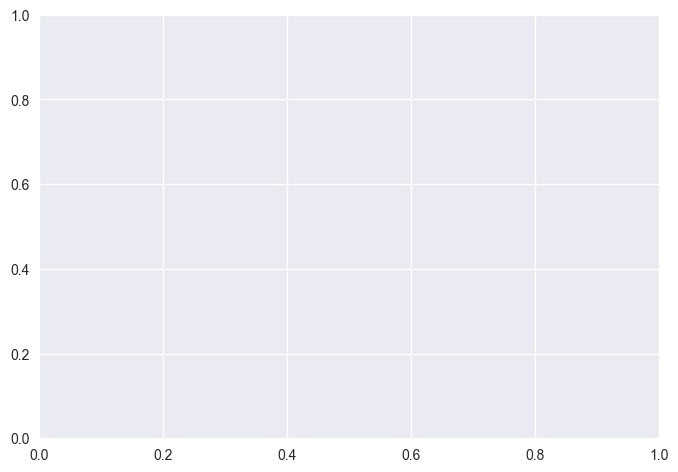

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

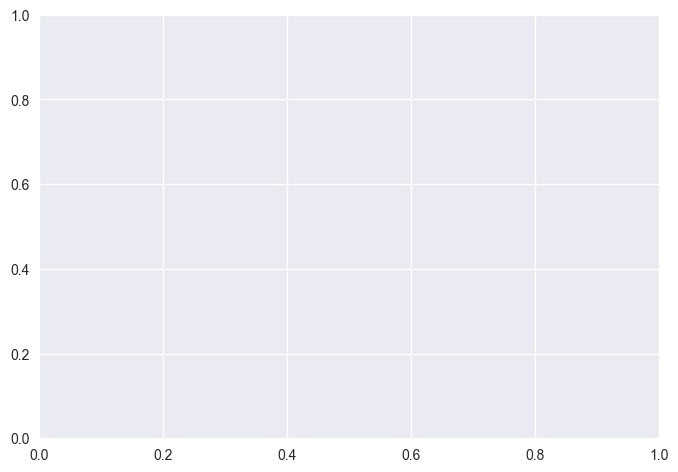

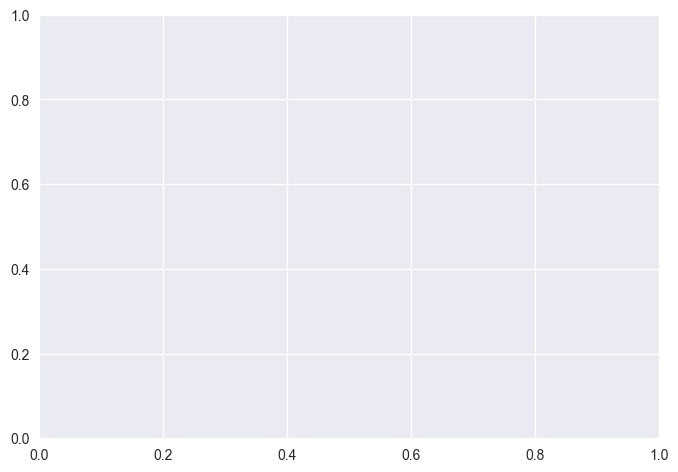

In [10]:
# 5. EVALUACIÓN CON PYCARET
# ====================================================================

class EvaluadorPyCaret:
    """
    Evaluador de modelos de clustering usando PyCaret.
    
    Esta clase encapsula la evaluación sistemática de múltiples algoritmos
    de clustering usando la biblioteca PyCaret, optimizada para el dominio
    de homologación de medicamentos.
    """
    
    def __init__(self, config: ConfiguracionClustering):
        """
        Inicializa el evaluador PyCaret.
        
        Args:
            config (ConfiguracionClustering): Configuración del clustering
        """
        self.config = config
        self.experimento = None
        self.resultados = {}
        
    def configurar_experimento(self, df: pd.DataFrame) -> None:
        """
        Configura el experimento de clustering en PyCaret.
        
        Args:
            df (pd.DataFrame): Dataset preparado para clustering
        """
        logger.info("🚀 Configurando experimento PyCaret")
        
        try:
            # Configurar PyCaret clustering
            self.experimento = clustering.setup(
                data=df,
                session_id=self.config.RANDOM_STATE,
                ignore_features=None,  # No ignorar features específicas
                transformation=True,   # Aplicar transformaciones
                normalize=True,        # Normalizar datos
                pca=False,            # No usar PCA inicialmente
            )
            
            logger.info("✅ Experimento PyCaret configurado exitosamente")
            
        except Exception as e:
            logger.error(f"❌ Error configurando experimento PyCaret: {str(e)}")
            raise
    
    def evaluar_modelos(self) -> pd.DataFrame:
        """
        Evalúa múltiples modelos de clustering.
        
        Returns:
            pd.DataFrame: Tabla comparativa de modelos
        """
        logger.info("🔍 Evaluando modelos de clustering con PyCaret")
        
        try:
            # Crear y evaluar modelos individualmente
            resultados_modelos = []
            
            for algoritmo in self.config.ALGORITMOS_PYCARET:
                try:
                    logger.info(f"🔧 Creando modelo: {algoritmo}")
                    modelo = clustering.create_model(algoritmo)
                    
                    # Asignar clusters y evaluar
                    modelo_asignado = clustering.assign_model(modelo)
                    
                    # Evaluar modelo
                    metricas = clustering.evaluate_model(modelo)
                    
                    # Guardar resultados
                    resultado = {
                        'Modelo': algoritmo,
                        'Objeto_Modelo': modelo,
                        'Datos_Asignados': modelo_asignado
                    }
                    
                    resultados_modelos.append(resultado)
                    logger.info(f"✅ Modelo {algoritmo} evaluado exitosamente")
                    
                except Exception as e:
                    logger.warning(f"⚠️ Error evaluando modelo {algoritmo}: {str(e)}")
                    continue
            
            # Crear DataFrame de resultados
            import pandas as pd
            resultados_comparacion = pd.DataFrame(resultados_modelos)
            
            logger.info(f"✅ Evaluación completada: {len(resultados_modelos)} modelos evaluados")
            
            # Guardar resultados
            self.resultados['comparacion'] = resultados_comparacion
            self.resultados['modelos'] = resultados_modelos
            
            return resultados_comparacion
            
        except Exception as e:
            logger.error(f"❌ Error en evaluación de modelos: {str(e)}")
            raise
    
    def entrenar_mejor_modelo(self, modelo_id: str = None) -> object:
        """
        Entrena el mejor modelo identificado.
        
        Args:
            modelo_id (str, optional): ID del modelo a entrenar. Si None, usa el mejor.
            
        Returns:
            object: Modelo entrenado
        """
        if modelo_id is None:
            # Usar el primer modelo de la comparación (mejor scoring)
            modelo_id = 'kmeans'  # Default seguro
            
        logger.info(f"🎯 Entrenando modelo: {modelo_id}")
        
        try:
            modelo_entrenado = clustering.create_model(modelo_id)
            logger.info(f"✅ Modelo {modelo_id} entrenado exitosamente")
            
            return modelo_entrenado
            
        except Exception as e:
            logger.error(f"❌ Error entrenando modelo {modelo_id}: {str(e)}")
            raise

# Evaluar con PyCaret
logger.info("🚀 INICIANDO EVALUACIÓN CON PYCARET")
print("=" * 60)

evaluador_pycaret = EvaluadorPyCaret(config)

# Configurar y evaluar
evaluador_pycaret.configurar_experimento(df_pycaret)
resultados_pycaret = evaluador_pycaret.evaluar_modelos()

print("✅ Evaluación PyCaret completada")
print(f"📊 Modelos evaluados: {len(config.ALGORITMOS_PYCARET)}")


## **PASO 6: Visualización de Resultados PyCaret**

### **Sistema de Visualización Comprehensiva**

Esta función crea un **dashboard visual completo** para analizar los resultados de PyCaret:

### **Diseño de Visualizaciones**

#### **Layout Principal**
- **Grid 2x2** con 4 gráficos complementarios
- **Título unificado** y estilo consistente
- **Adaptación automática** a métricas disponibles

#### **Gráficos Generados**

1. **Gráfico 1**: Silhouette Score por Modelo
   - Gráfico de barras horizontales
   - Comparación directa de rendimiento
   - Identificación visual del mejor modelo

2. **Gráfico 2**: Segunda Métrica Disponible
   - Calinski-Harabasz o Davies-Bouldin
   - Validación cruzada de resultados
   - Confirmación de patrones

3. **Gráfico 3**: Comparación Bidimensional
   - Scatter plot de métricas principales
   - Análisis de correlación entre métricas
   - Identificación de outliers

4. **Gráfico 4**: Ranking de Modelos
   - Ranking visual ordenado
   - Identificación clara del ganador
   - Comparación relativa de rendimiento

### **Tabla de Resultados**
- **Tabla formatted** con todos los resultados
- **Métricas numéricas** precisas
- **Comparación detallada** modelo por modelo

### **Interpretación Visual**
- **Identificación rápida** del mejor algoritmo
- **Análisis de trade-offs** entre métricas
- **Validación** de consistencia en resultados

---

2025-06-21 16:44:13,130 - INFO - 📊 Generando visualizaciones de resultados PyCaret


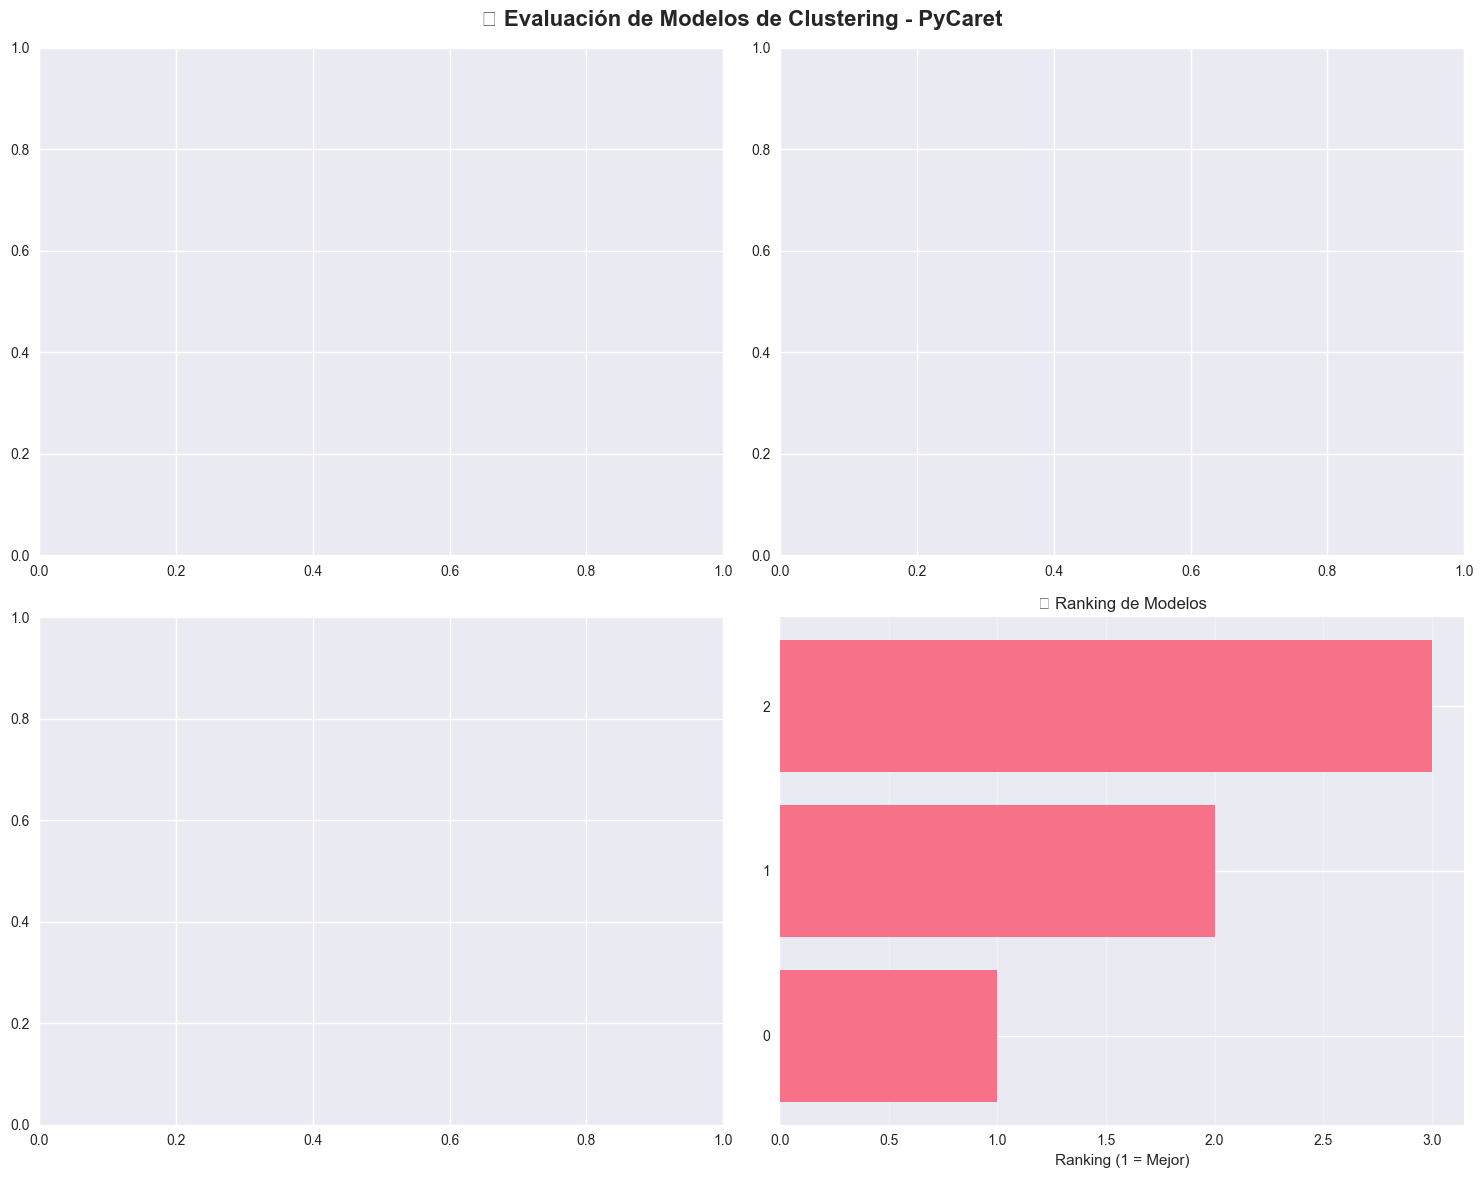


📋 TABLA DE RESULTADOS PYCARET:
   Modelo                          Objeto_Modelo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [11]:
# 6. VISUALIZACIÓN DE RESULTADOS PYCARET
# ====================================================================

def visualizar_resultados_pycaret(resultados: pd.DataFrame) -> None:
    """
    Crea visualizaciones de los resultados de PyCaret.
    
    Args:
        resultados (pd.DataFrame): Resultados de la comparación de modelos
    """
    logger.info("📊 Generando visualizaciones de resultados PyCaret")
    
    # Configuración de la figura
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🧪 Evaluación de Modelos de Clustering - PyCaret', fontsize=16, fontweight='bold')
    
    # Métricas disponibles (ajustar según las columnas reales)
    metricas_disponibles = [col for col in resultados.columns if col in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']]
    
    if len(metricas_disponibles) >= 1:
        # Gráfico 1: Silhouette Score
        ax1 = axes[0, 0]
        metrica1 = metricas_disponibles[0]
        ax1.barh(range(len(resultados)), resultados[metrica1])
        ax1.set_yticks(range(len(resultados)))
        ax1.set_yticklabels(resultados.index)
        ax1.set_xlabel(metrica1)
        ax1.set_title(f'📊 {metrica1} por Modelo')
        ax1.grid(axis='x', alpha=0.3)
    
    if len(metricas_disponibles) >= 2:
        # Gráfico 2: Segunda métrica
        ax2 = axes[0, 1]
        metrica2 = metricas_disponibles[1]
        ax2.barh(range(len(resultados)), resultados[metrica2])
        ax2.set_yticks(range(len(resultados)))
        ax2.set_yticklabels(resultados.index)
        ax2.set_xlabel(metrica2)
        ax2.set_title(f'📊 {metrica2} por Modelo')
        ax2.grid(axis='x', alpha=0.3)
    
    # Gráfico 3: Comparación general
    ax3 = axes[1, 0]
    if len(metricas_disponibles) >= 2:
        ax3.scatter(resultados[metricas_disponibles[0]], resultados[metricas_disponibles[1]])
        for i, modelo in enumerate(resultados.index):
            ax3.annotate(modelo, (resultados[metricas_disponibles[0]].iloc[i], 
                                resultados[metricas_disponibles[1]].iloc[i]))
        ax3.set_xlabel(metricas_disponibles[0])
        ax3.set_ylabel(metricas_disponibles[1])
        ax3.set_title('🎯 Comparación de Métricas')
        ax3.grid(alpha=0.3)
    
    # Gráfico 4: Ranking de modelos
    ax4 = axes[1, 1]
    ranking = list(range(1, len(resultados) + 1))
    ax4.barh(range(len(resultados)), ranking)
    ax4.set_yticks(range(len(resultados)))
    ax4.set_yticklabels(resultados.index)
    ax4.set_xlabel('Ranking (1 = Mejor)')
    ax4.set_title('🏆 Ranking de Modelos')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de resultados
    print("\n📋 TABLA DE RESULTADOS PYCARET:")
    print("=" * 50)
    print(resultados.to_string())

# Generar visualizaciones
visualizar_resultados_pycaret(resultados_pycaret)

print("\n✅ Visualización de resultados PyCaret completada")